In [1]:
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def DataLoader(file_name):
    df=pd.read_csv(file_name)
    print(df.shape)
    print(df.columns)
    # print("Time:\n")
    # print(df['Time'].describe())
    # print("Amount:\n")
    # print(df['Amount'].describe())
    # print("Class:\n")
    # print(df['Class'].describe())
    # print(df['Class'].value_counts())
    # print(df)
    return df

In [3]:

df=DataLoader('creditcard.csv')


(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [5]:
def data_sampling(df):
    # print(df)
    fraud_data=df[df['Class']==1]
    normal_data=df[df['Class']==0].sample(n=len(fraud_data)*10,random_state=42)
    # print(fraud_data.shape)
    # print(normal_data.shape)
    selected_df=pd.concat([normal_data,fraud_data])
    selected_df.reset_index(drop=True,inplace=True)
    return selected_df

In [6]:
df=data_sampling(df)
print(df.index)

RangeIndex(start=0, stop=5412, step=1)


In [7]:
def data_standardization(df):
    # 假設 df 是你的 DataFrame，columns 是要標準化的欄位名稱列表
    columns_to_normalize = ['Time', 'Amount']  # 填入要標準化的欄位名稱
    # 初始化 StandardScaler 物件
    scaler = StandardScaler()
    # 對指定列進行標準化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df



In [8]:
df=data_standardization(df)


In [9]:
def calculate_cosine_similarity(df):
    features=df.drop("Class",axis=1)
    cos_sim=cosine_similarity(features)
    np.save("cos_sim.npy",cos_sim)
    print("Cosine similarity calculation completed and saved.") 

In [10]:
cos_sim=np.load("cos_sim.npy")
print(cos_sim)
print(cos_sim.shape)

[[ 1.         -0.10474847 -0.17063587 ...  0.00880987  0.19544622
   0.52532881]
 [-0.10474847  1.          0.35448425 ... -0.07256405 -0.13313727
  -0.33534979]
 [-0.17063587  0.35448425  1.         ... -0.11640662 -0.14318716
  -0.26465308]
 ...
 [ 0.00880987 -0.07256405 -0.11640662 ...  1.          0.89628544
   0.18719061]
 [ 0.19544622 -0.13313727 -0.14318716 ...  0.89628544  1.
   0.22006893]
 [ 0.52532881 -0.33534979 -0.26465308 ...  0.18719061  0.22006893
   1.        ]]
(5412, 5412)


In [11]:
def cos_sim_describe(cos_sim):
    # 計算每一列的統計量
    max_values = np.max(cos_sim, axis=1)
    min_values = np.min(cos_sim, axis=1)
    median_values = np.median(cos_sim, axis=1)
    mean_values = np.mean(cos_sim, axis=1)
    std_values = np.std(cos_sim, axis=1)

    # 對這些統計量再次計算統計量
    stats_max = np.max(max_values)
    stats_min = np.min(min_values)
    stats_median = np.median(median_values)
    stats_mean = np.mean(mean_values)
    stats_std = np.std(std_values)

    # 印出結果
    print("Statistics of row statistics:")
    print("  Max:", stats_max)
    print("  Min:", stats_min)
    print("  Median:", stats_median)
    print("  Mean:", stats_mean)
    print("  Std:", stats_std)
    cos_sim_dict={'max':stats_max,'min':stats_min,'median':stats_median
                  ,'mean':stats_mean,'std':stats_std}
    return cos_sim_dict

In [12]:
cos_sim_dict=cos_sim_describe(cos_sim)
print(cos_sim_dict)

Statistics of row statistics:
  Max: 1.000000000000001
  Min: -0.8610622522995957
  Median: -0.020403275449845982
  Mean: 0.007676525874176422
  Std: 0.031593458544467296
{'max': 1.000000000000001, 'min': -0.8610622522995957, 'median': -0.020403275449845982, 'mean': 0.007676525874176422, 'std': 0.031593458544467296}


In [13]:
## graph construction
import networkx as nx

In [14]:
def graph_construction(cos_sim,df,threshold):
    G=nx.Graph()
    for i in tqdm(range(cos_sim.shape[0]),desc="Add nodes into G..."):
        node_name=i
        feature=(df.iloc[i]).to_dict()
        G.add_node(node_name,**feature)

    for i in tqdm(range(cos_sim.shape[0]),desc="Graph Construction..."):
        for j in range(i+1,cos_sim.shape[1]):
            if cos_sim[i,j]>threshold:
                G.add_edge(i,j)
    return G


In [15]:
from collections import Counter
def graph_describe(G,round_digit):
    # print("Number of nodes:",G.number_of_nodes())
    # print("Number of edges:",G.number_of_edges())
    density=2*G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))
    # print(f"density = {round(density,round_digit)}")
    # print("Degree:")
    # 获取节点的度数
    degrees = [degree for node, degree in G.degree()]
    # 计算统计指标
    mean_degree = np.mean(degrees)
    median_degree = np.median(degrees)
    std_degree = np.std(degrees)
    max_degree = np.max(degrees)
    min_degree = np.min(degrees)
    # # 打印结果
    # print("Mean Degree:", round(mean_degree,round_digit))
    # print("Median Degree:", round(median_degree,round_digit))
    # print("Standard Deviation of Degree:", round(std_degree,round_digit))
    # print("Max Degree:", round(max_degree,round_digit))
    # print("Min Degree:", round(min_degree,round_digit))

    edge_consistency={}
    fraud_node_set=set()
    for edge in tqdm(G.edges(),desc="Check edge consistent..."):
        node1_class=G.nodes[edge[0]]['Class']
        node2_class=G.nodes[edge[1]]['Class']

        if node1_class==node2_class:
            edge_consistency[edge]=1
        else:
            edge_consistency[edge]=0

    value_counts=Counter(edge_consistency.values())
    # print(value_counts)
    ratio=value_counts[0]/G.number_of_edges()
    # print(f"The ratio of heterogeneous edges is:{round(ratio,round_digit)}")
    return G.number_of_nodes(),G.number_of_edges(),density,mean_degree,median_degree,std_degree,max_degree,min_degree,ratio

In [27]:
data_dic={'threshold':[],'number_of_nodes':[],'number_of_edges':[],'density':[]
          ,'mean_degree':[],'median_degree':[],'std_of_degree':[],'max_degree':[]
          ,'min_degree':[],'ratio_of_heterogeneous':[]}
graph=[]
for factor in range(31):
    threshold=cos_sim_dict['median']+factor*cos_sim_dict['std']
    data_dic['threshold'].append(threshold)
    G=graph_construction(cos_sim,df,threshold)
    graph.append(G)
    non,noe,d,meand,medd,stdd,maxd,mind,ratio=graph_describe(G,3)
    data_dic['number_of_nodes'].append(non)
    data_dic['number_of_edges'].append(noe)
    data_dic['density'].append(d)
    data_dic['mean_degree'].append(meand)
    data_dic['median_degree'].append(medd)
    data_dic['std_of_degree'].append(stdd)
    data_dic['max_degree'].append(maxd)
    data_dic['min_degree'].append(mind)
    data_dic['ratio_of_heterogeneous'].append(ratio)



Check edge consistent...: 100%|██████████| 14967/14967 [00:00<00:00, 489585.71it/s]


In [28]:

import json
for key in data_dic:
    if isinstance(data_dic[key][0], np.int32):
        data_dic[key]=[int(num) for num in data_dic[key]]
    elif isinstance(data_dic[key][0], np.float64):
        data_dic[key]=[float(num) for num in data_dic[key]]
json_data=json.dumps(data_dic,indent=4)
with open('data.json','w') as json_file:
    json_file.write(json_data)
with open("data.json",'r') as json_file:
    data_dic=json.load(json_file)
type_list=[]
for key in data_dic:
    print(f"{key}:")
    print([round(num,3) for num in data_dic[key]])
    print(f"type:{type(data_dic[key][0])}")
    type_list.append(type(data_dic[key][0]))
    print()
print(type_list)

threshold:
[-0.02, 0.011, 0.043, 0.074, 0.106, 0.138, 0.169, 0.201, 0.232, 0.264, 0.296, 0.327, 0.359, 0.39, 0.422, 0.453, 0.485, 0.517, 0.548, 0.58, 0.611, 0.643, 0.675, 0.706, 0.738, 0.769, 0.801, 0.833, 0.864, 0.896, 0.927]
type:<class 'float'>

number_of_nodes:
[5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412]
type:<class 'int'>

number_of_edges:
[7214068, 6344668, 5579009, 4902005, 4301888, 3769543, 3295381, 2871974, 2495539, 2159647, 1861323, 1597259, 1365082, 1161080, 983682, 829075, 695099, 579985, 480836, 395915, 324153, 263023, 211632, 168895, 134227, 105258, 81237, 60284, 42856, 27601, 14967]
type:<class 'int'>

density:
[0.493, 0.433, 0.381, 0.335, 0.294, 0.257, 0.225, 0.196, 0.17, 0.147, 0.127, 0.109, 0.093, 0.079, 0.067, 0.057, 0.047, 0.04, 0.033, 0.027, 0.022, 0.018, 0.014, 0.012, 0.009, 0.007, 0.006, 0.004, 0.003, 0.002, 0.001]
type:<c

plot...: 0it [00:00, ?it/s]C:\Users\aeiou\AppData\Local\Temp\ipykernel_12216\1661308731.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_nodes = random.sample(G.nodes(), k=30)
plot...: 20it [00:13,  1.32it/s]C:\Users\aeiou\AppData\Local\Temp\ipykernel_12216\1661308731.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))
plot...: 31it [00:15,  1.98it/s]


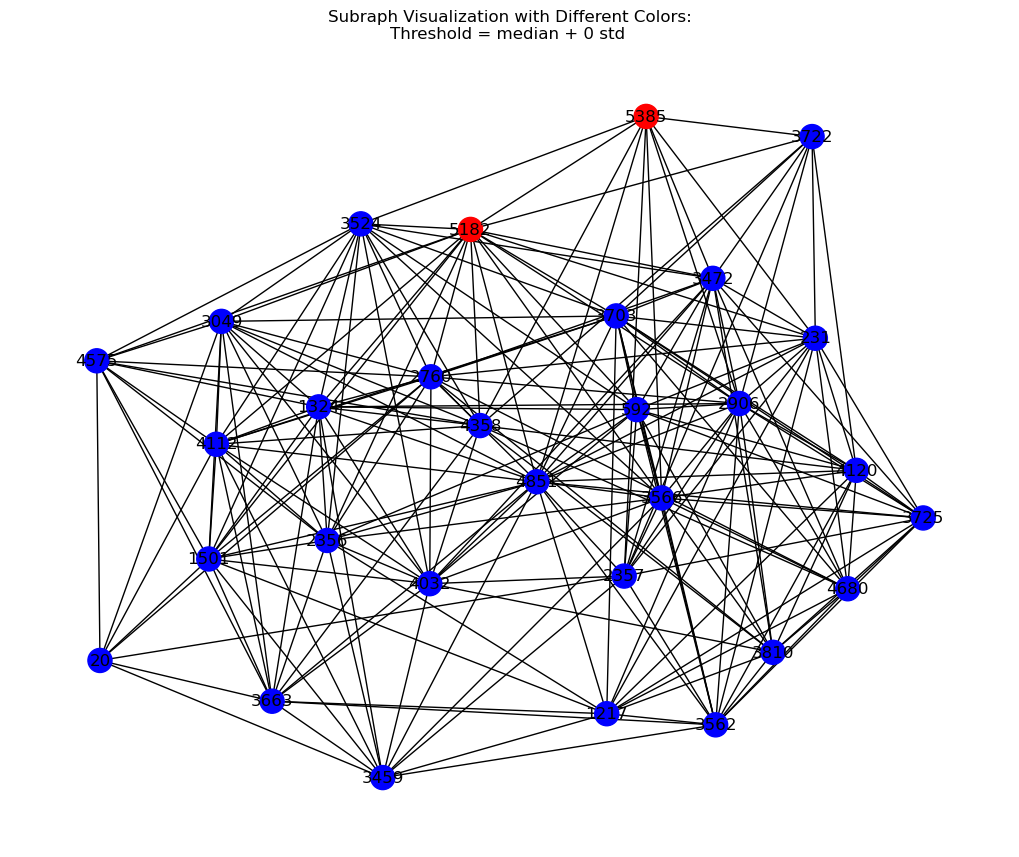

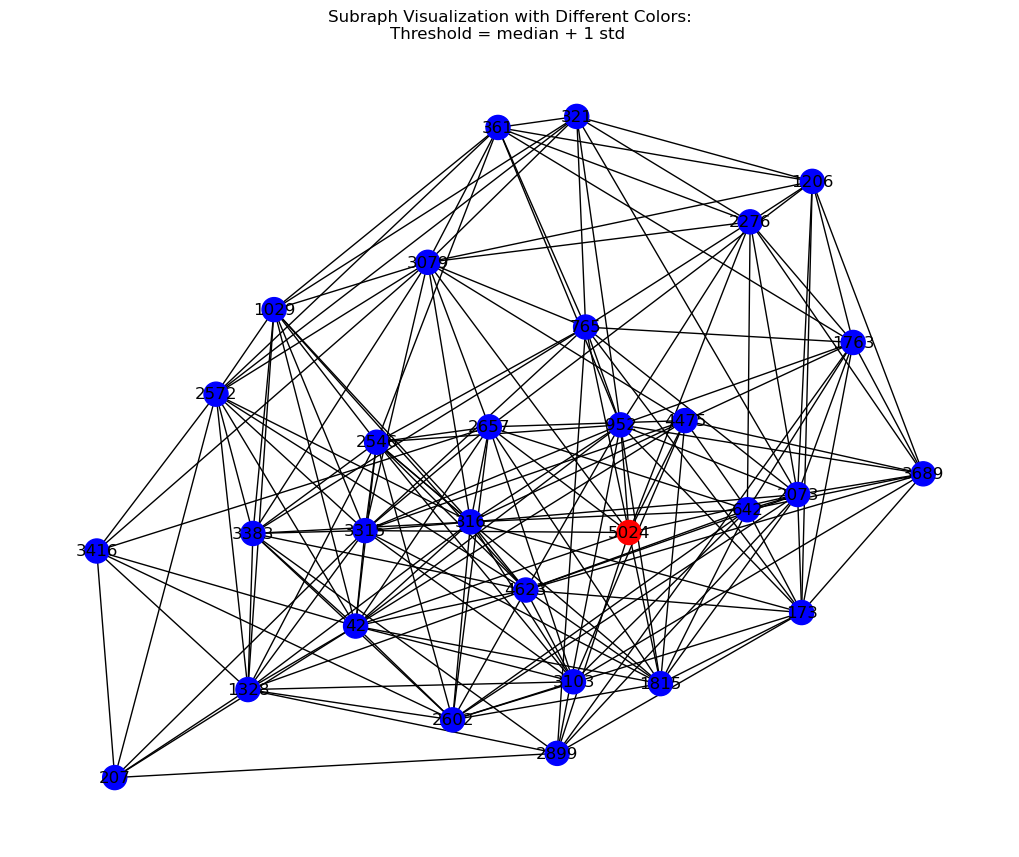

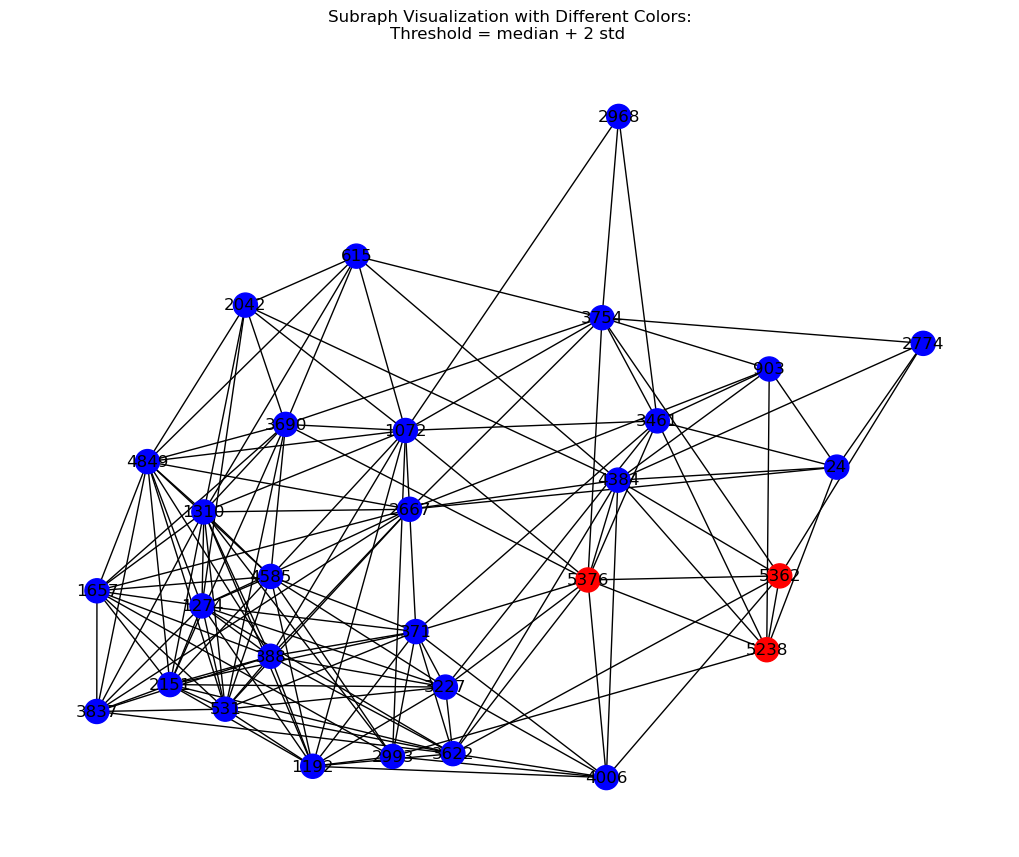

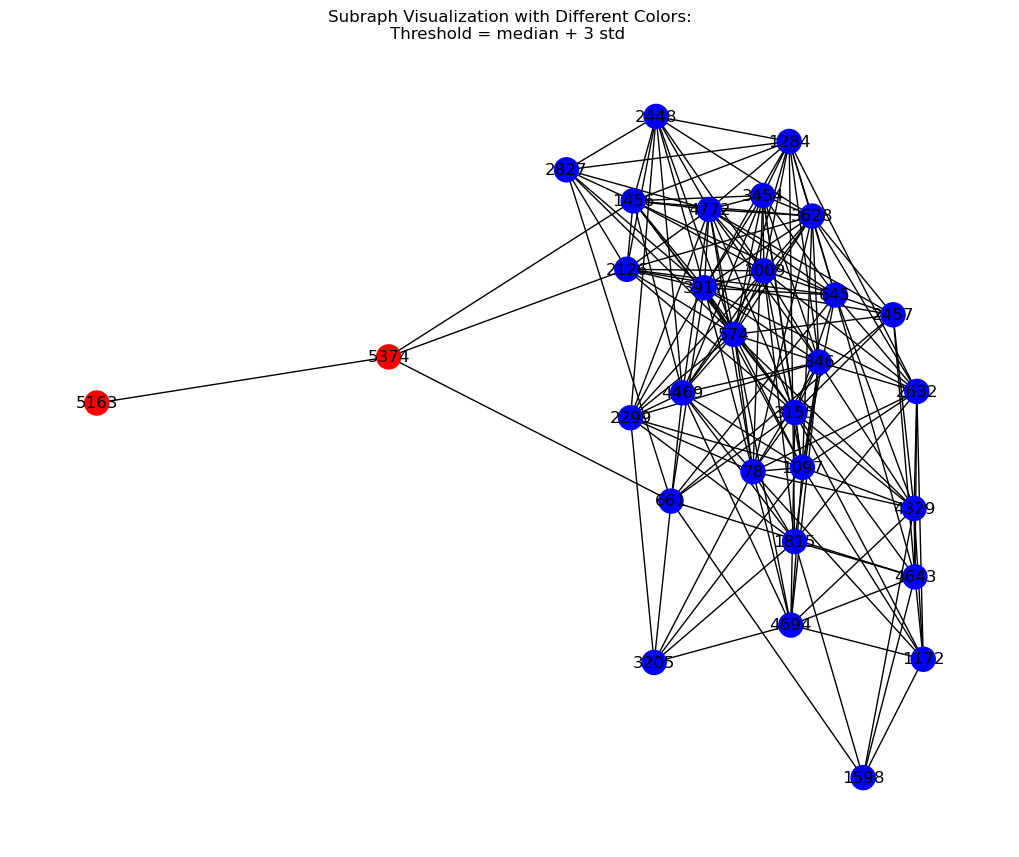

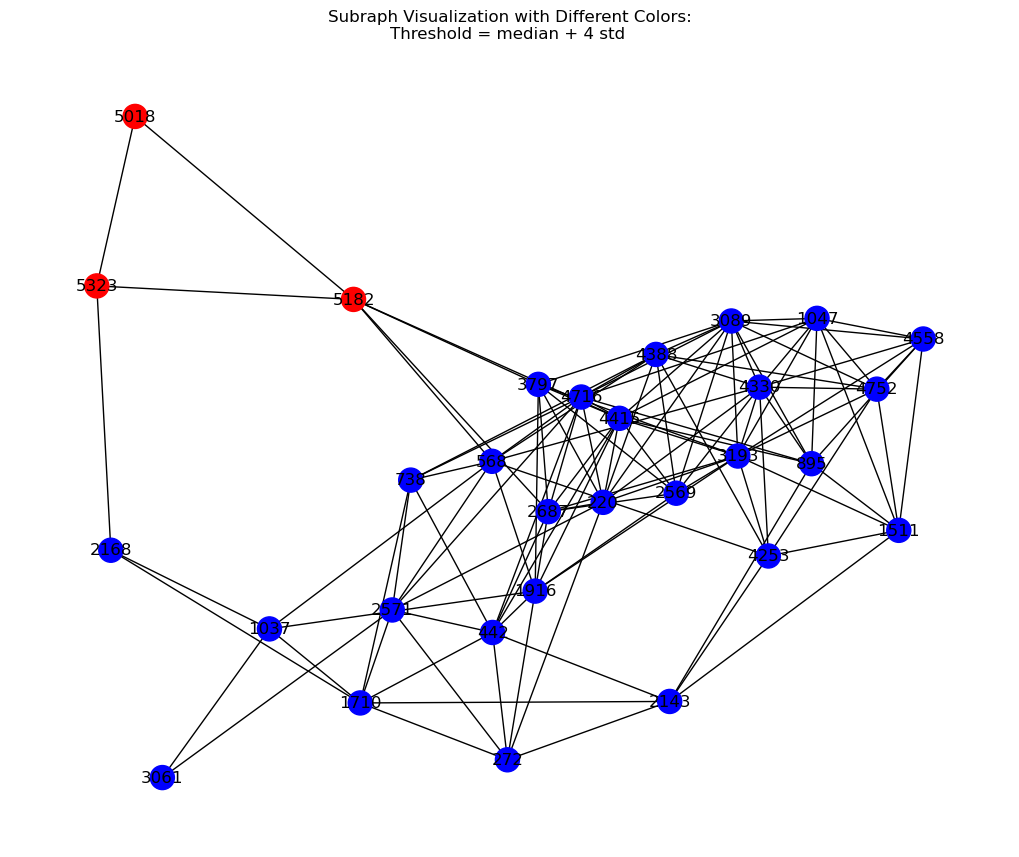

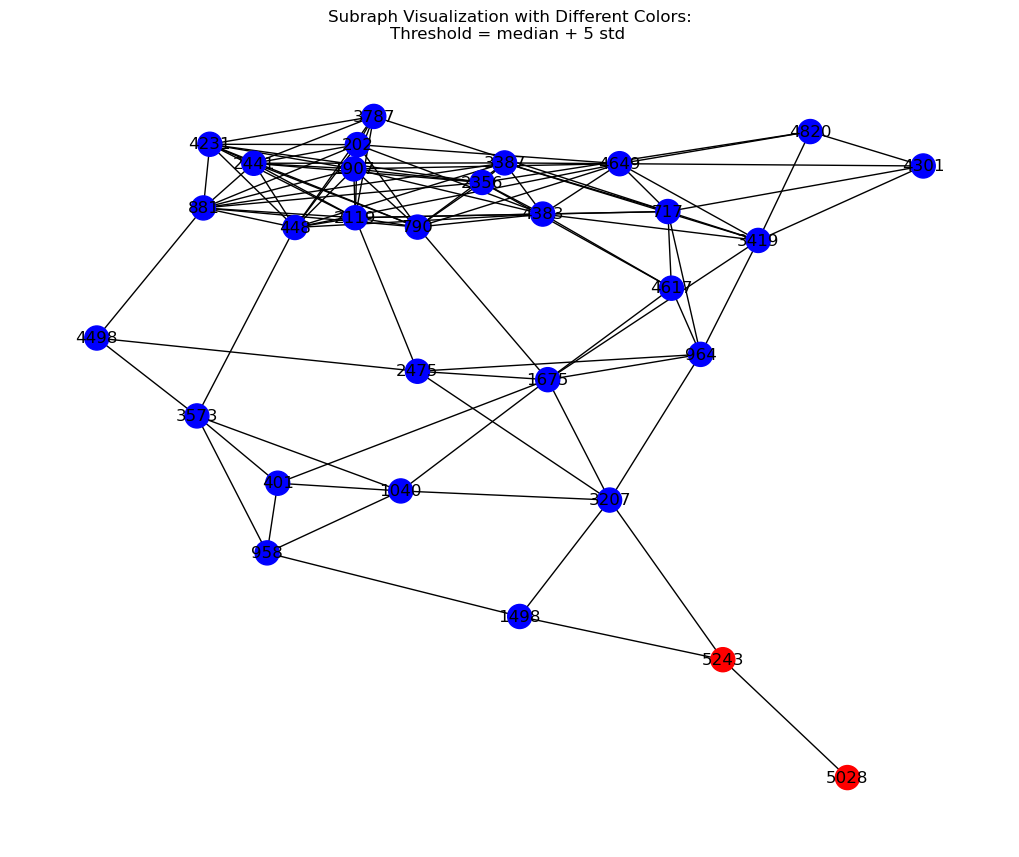

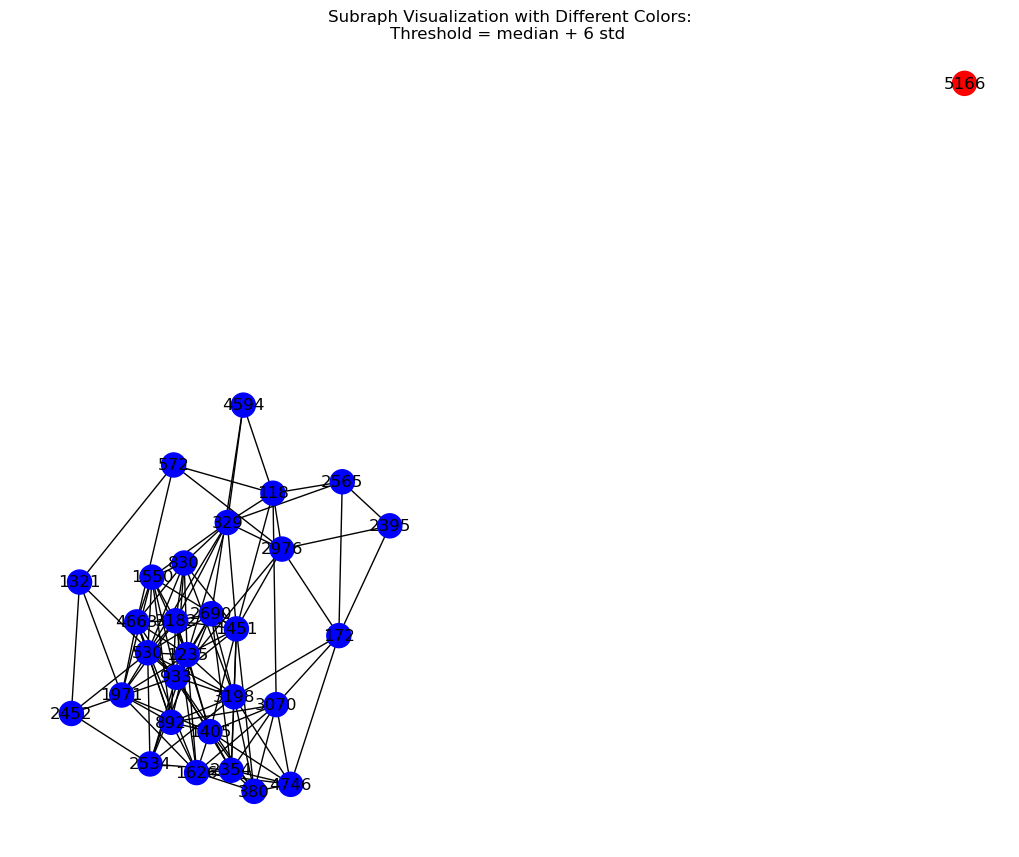

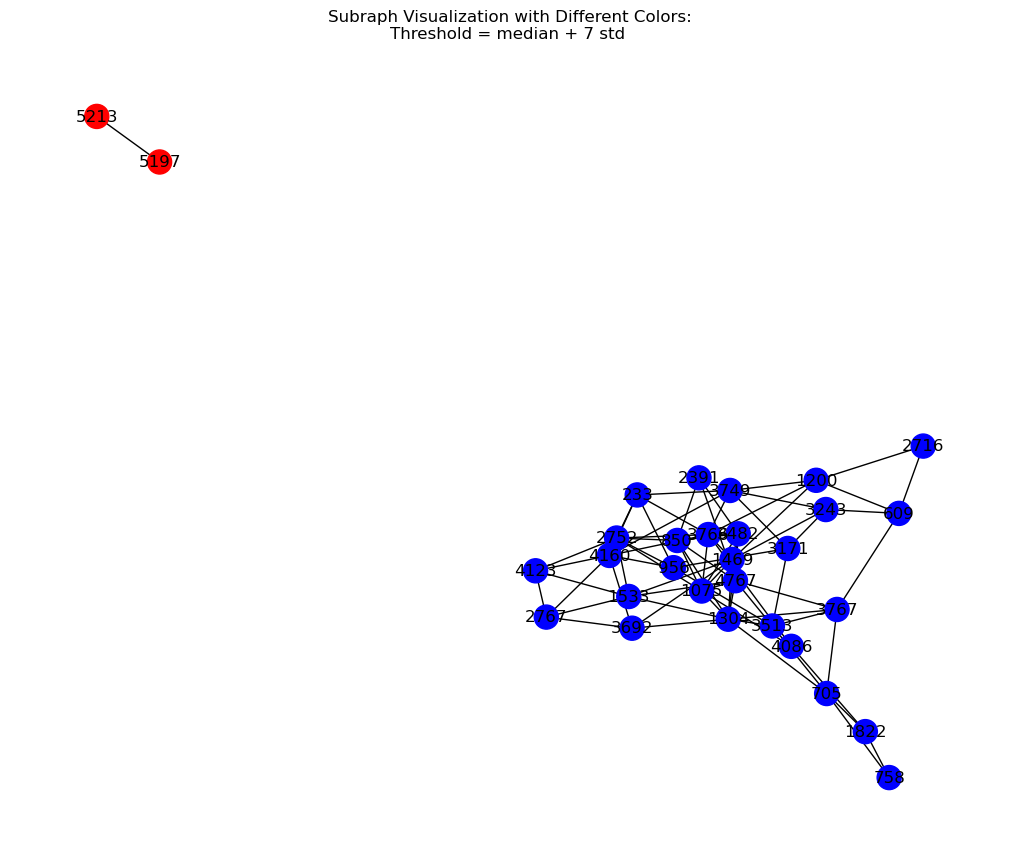

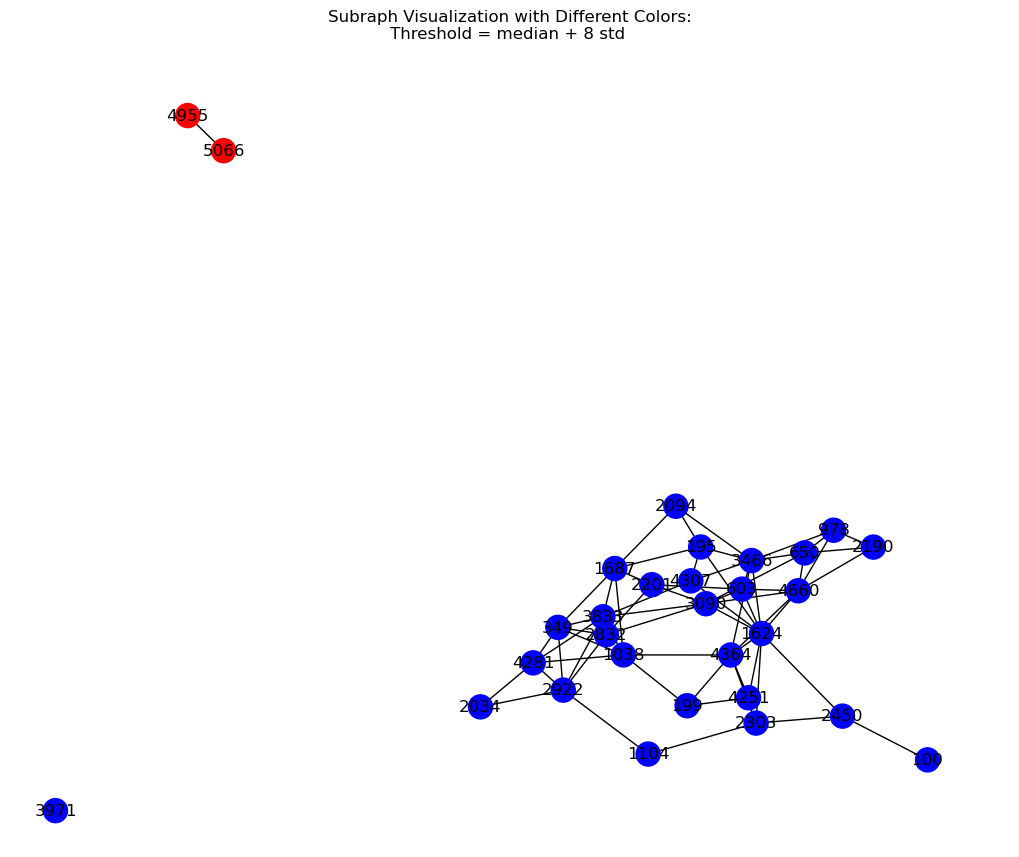

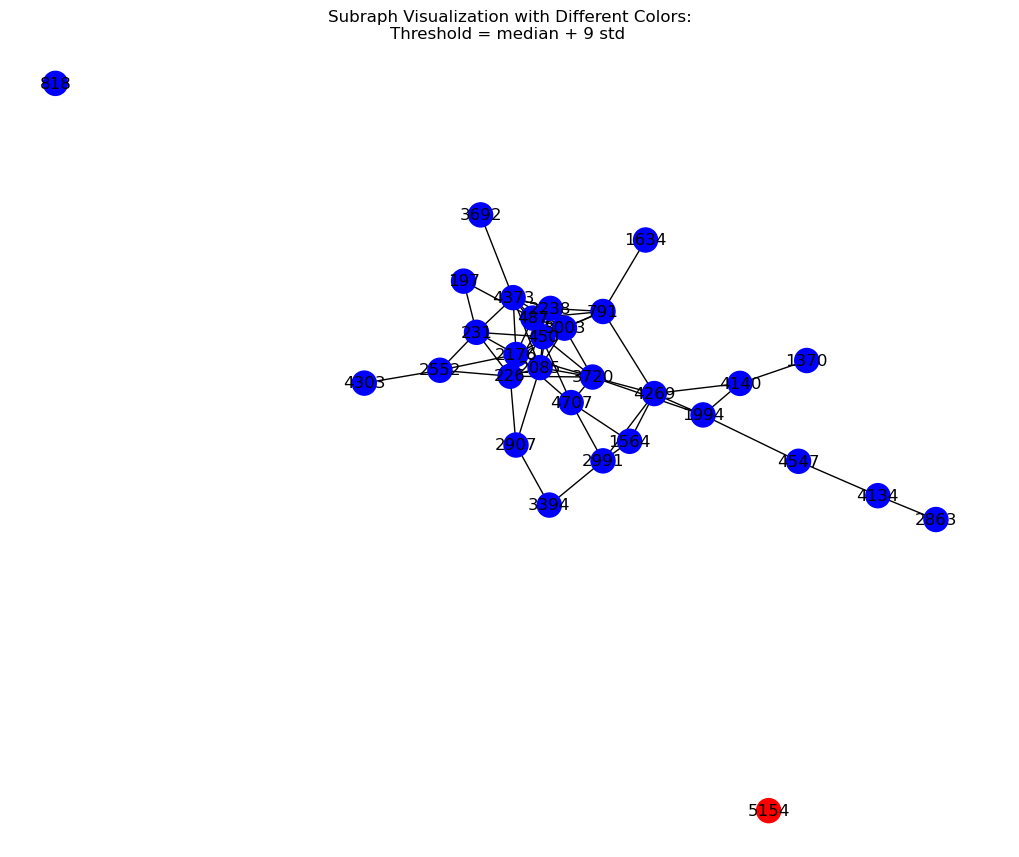

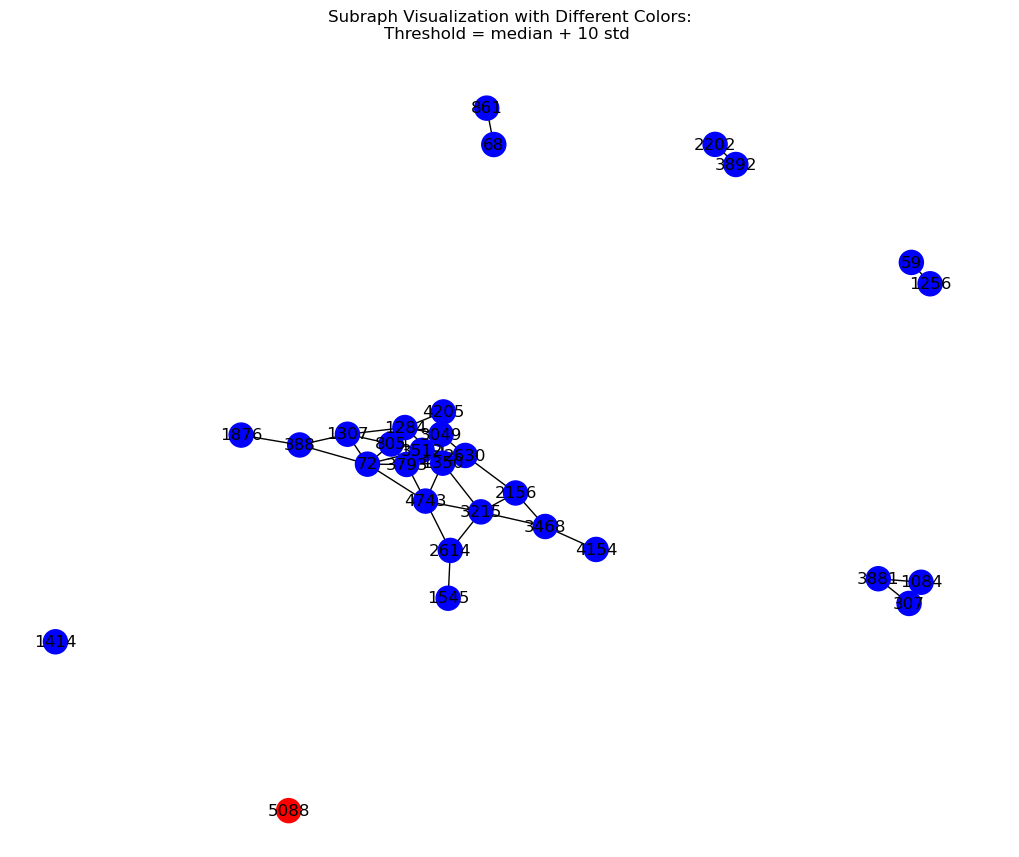

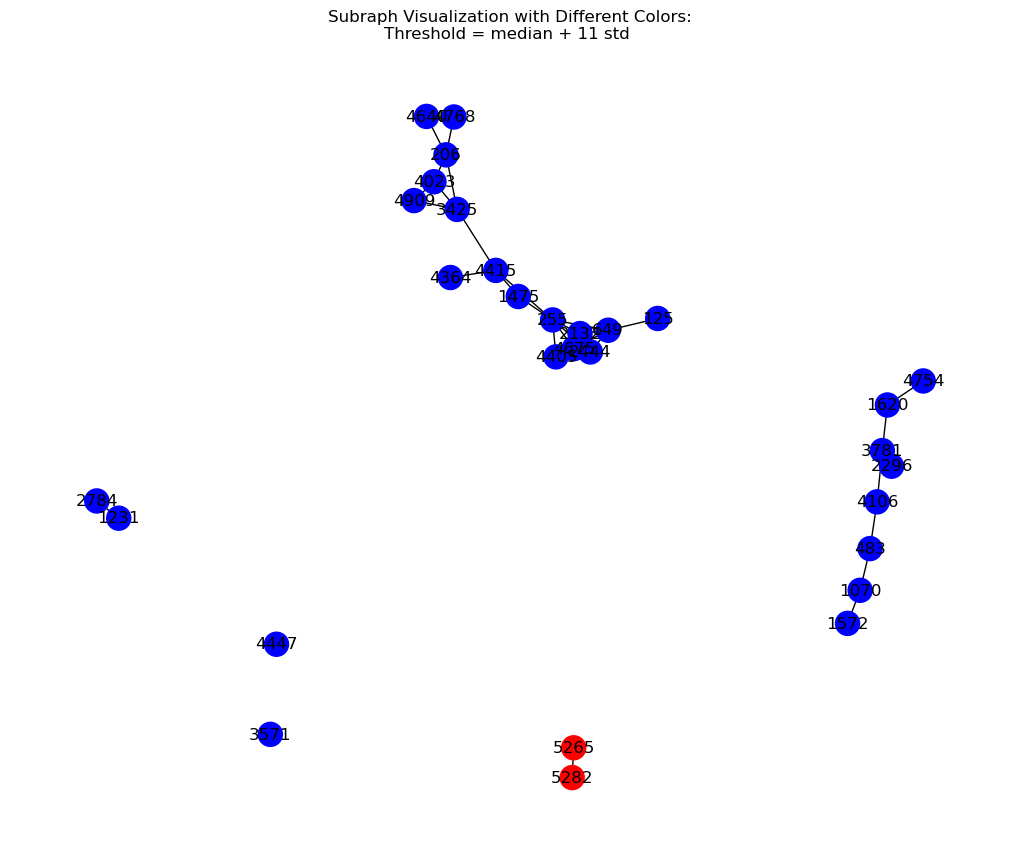

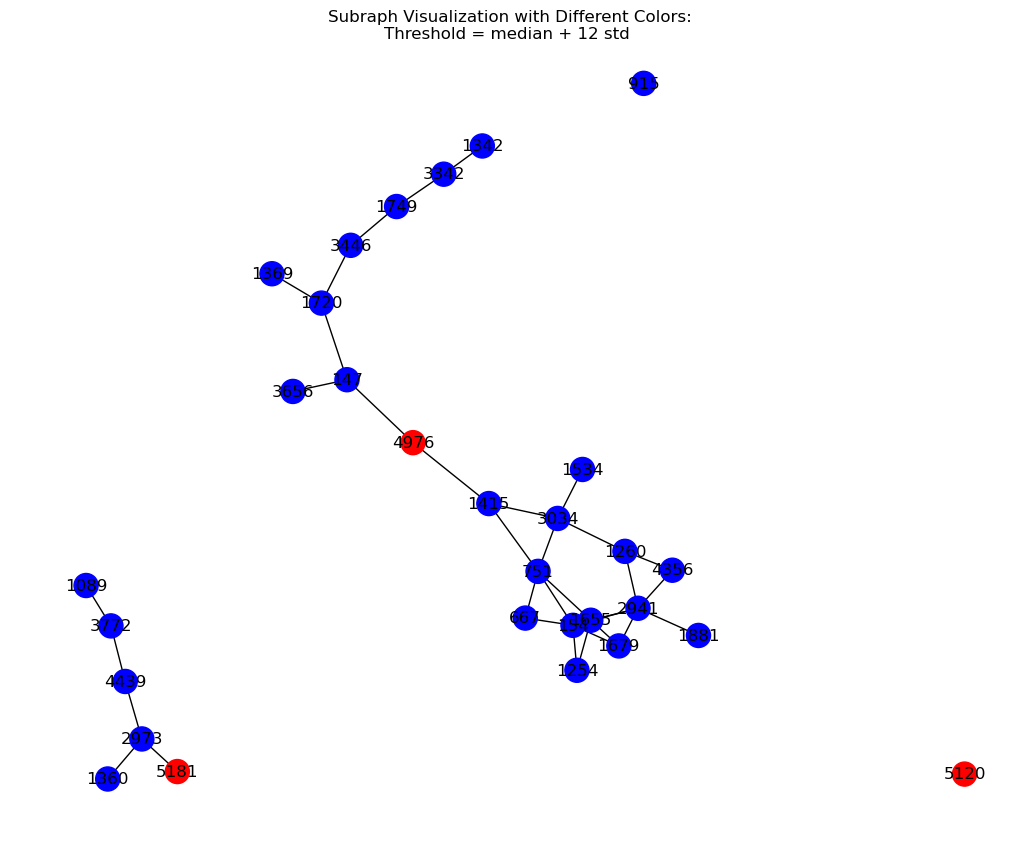

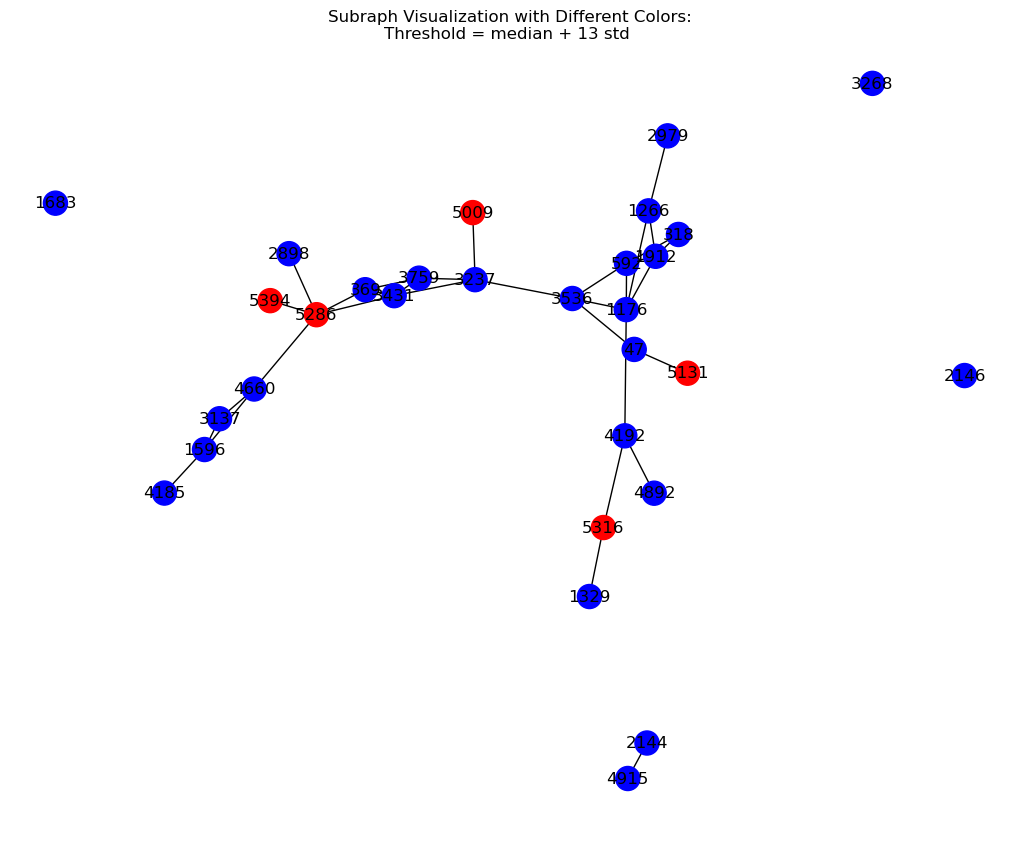

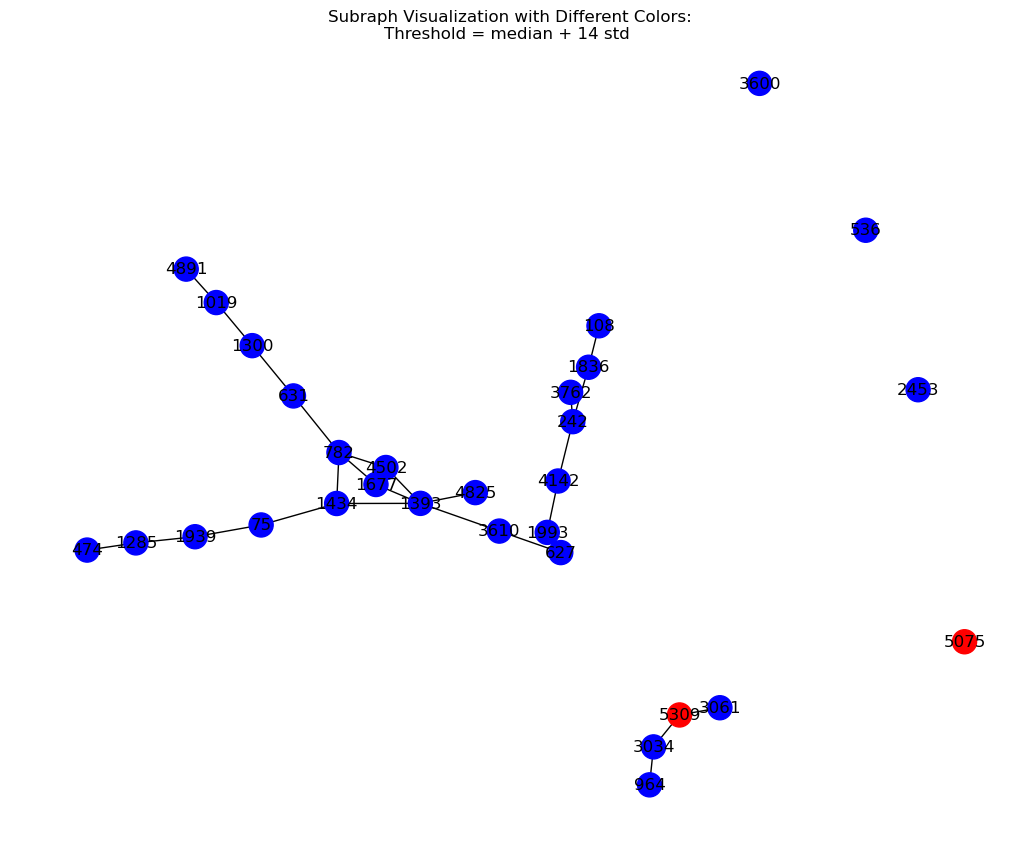

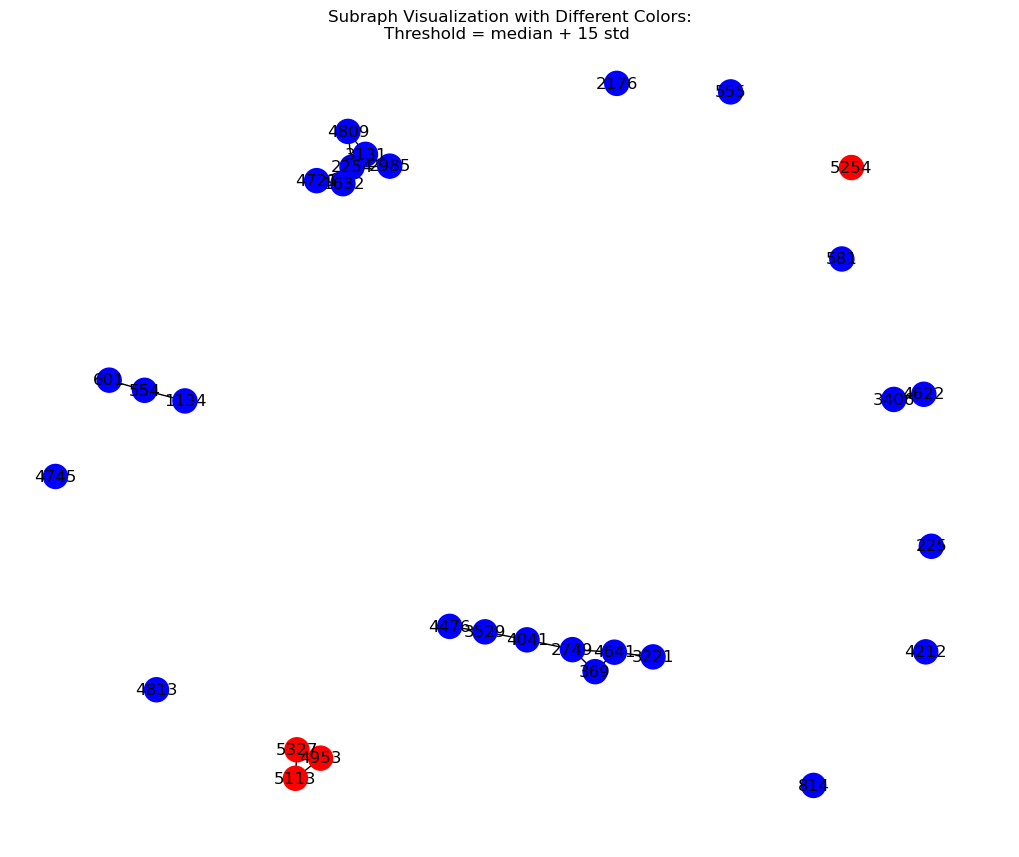

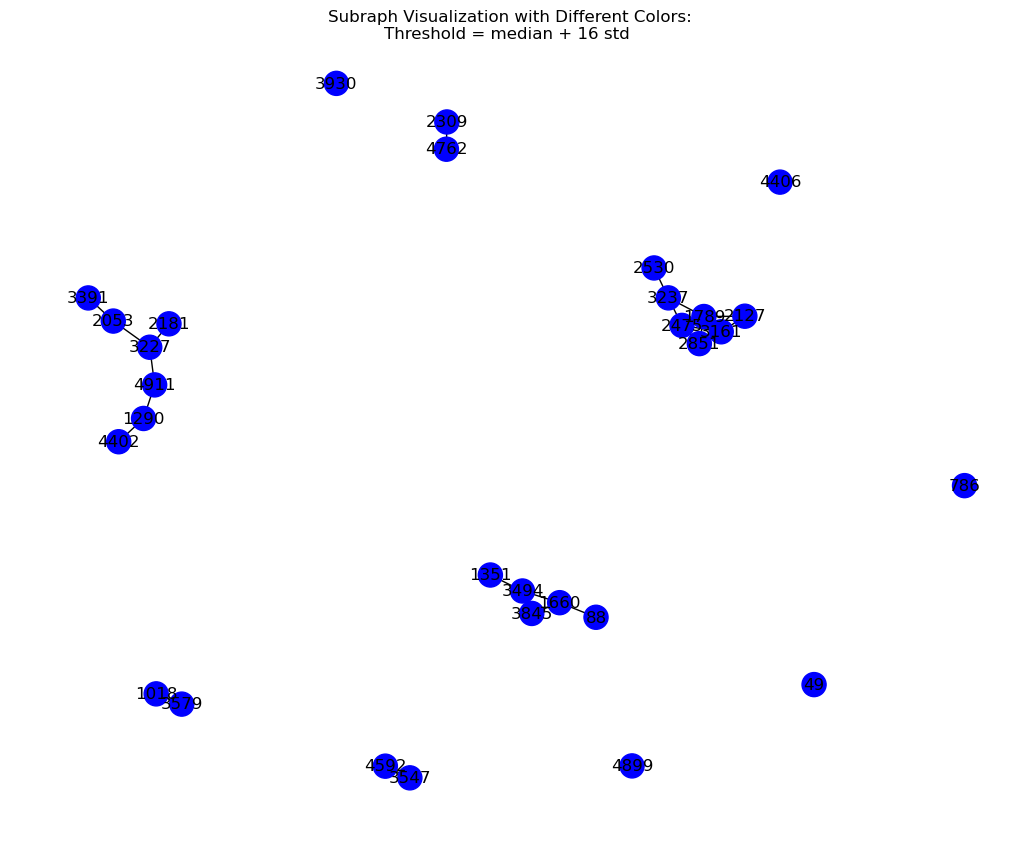

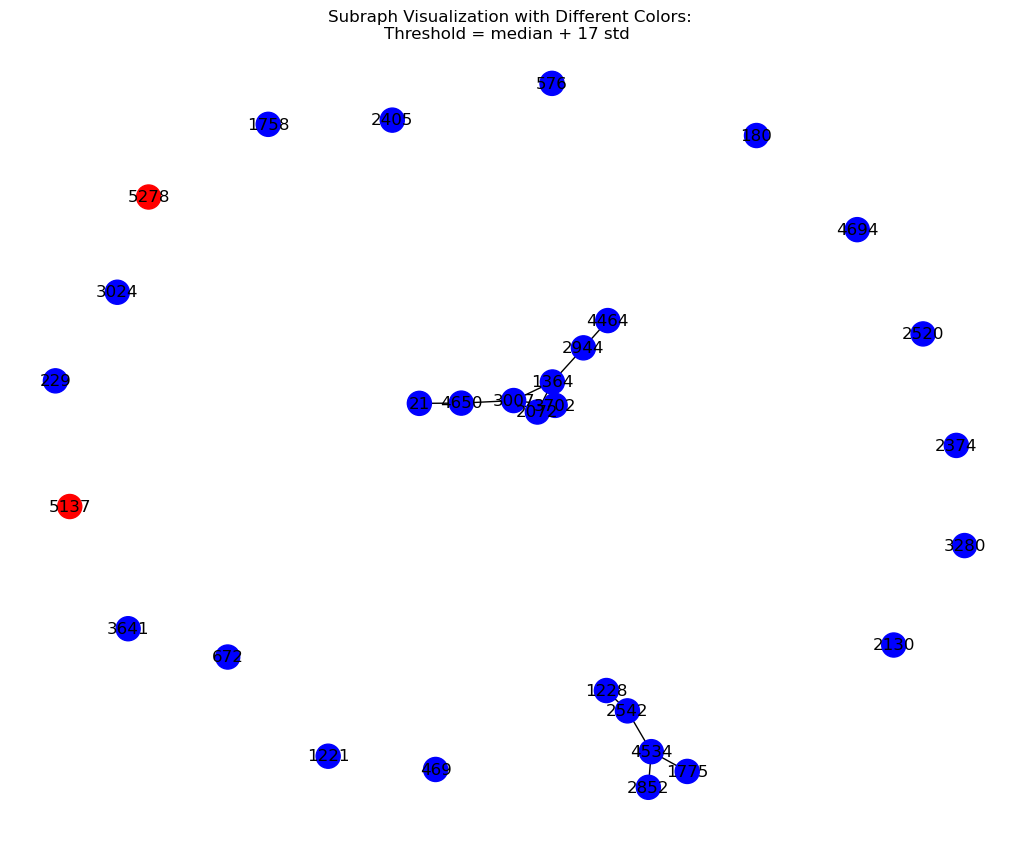

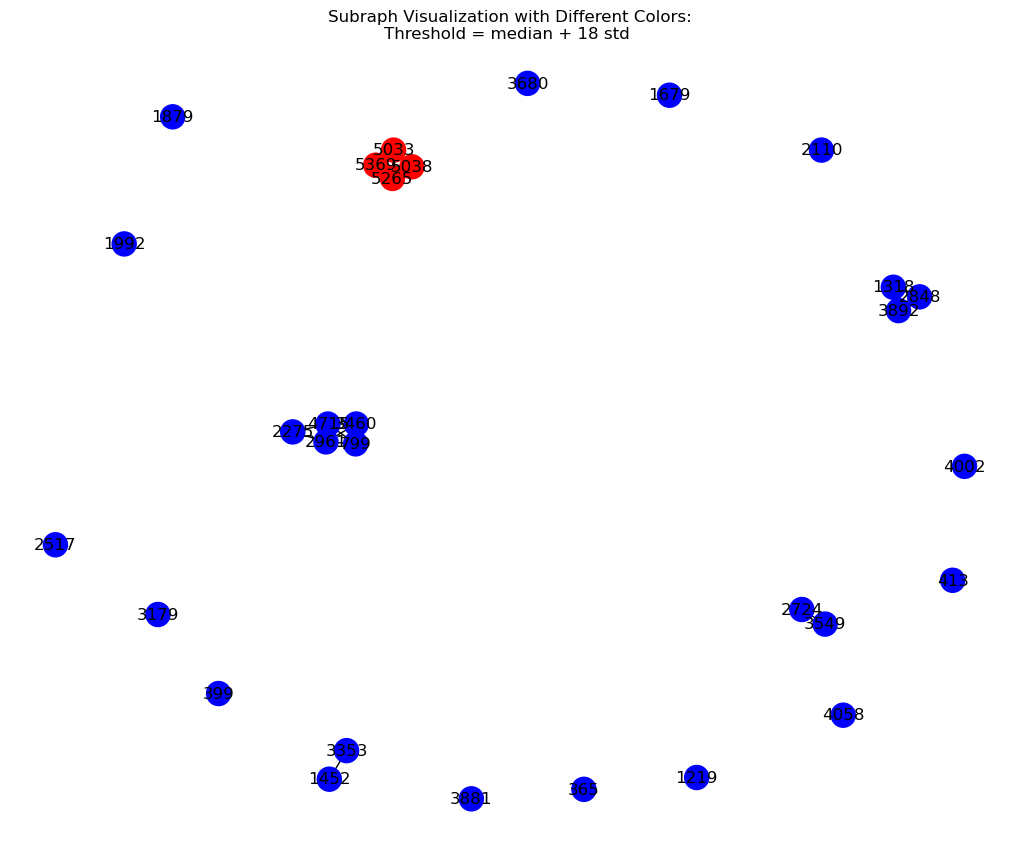

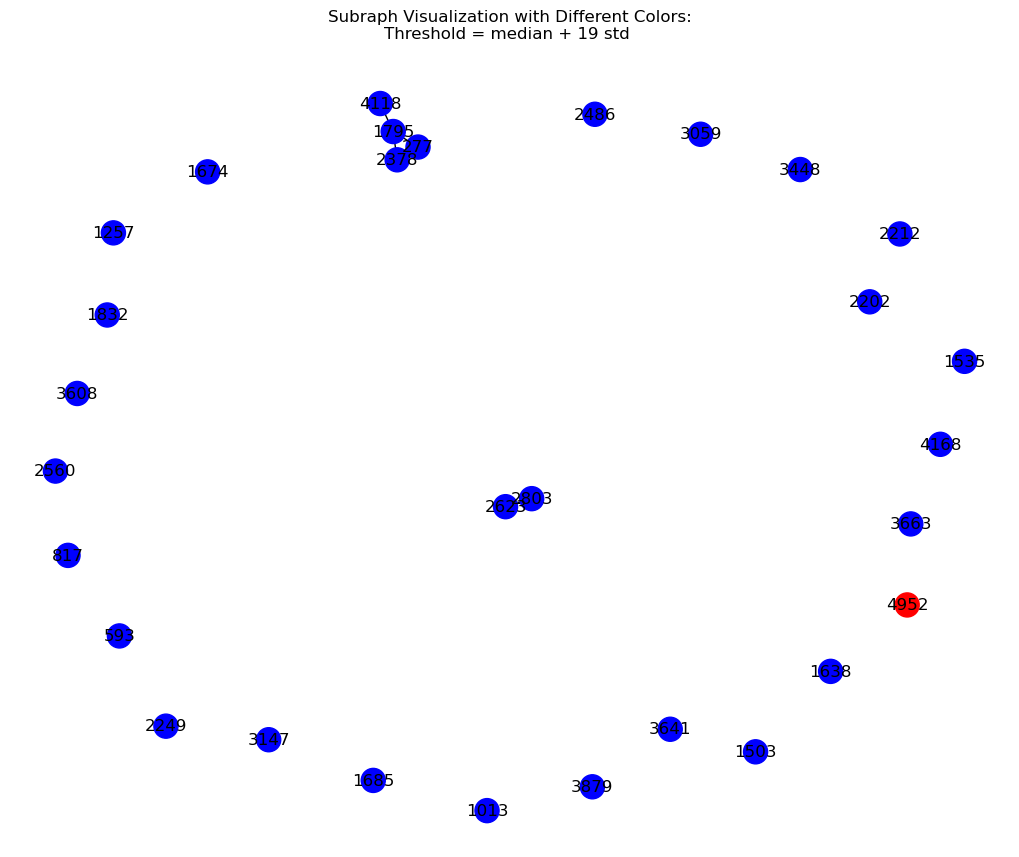

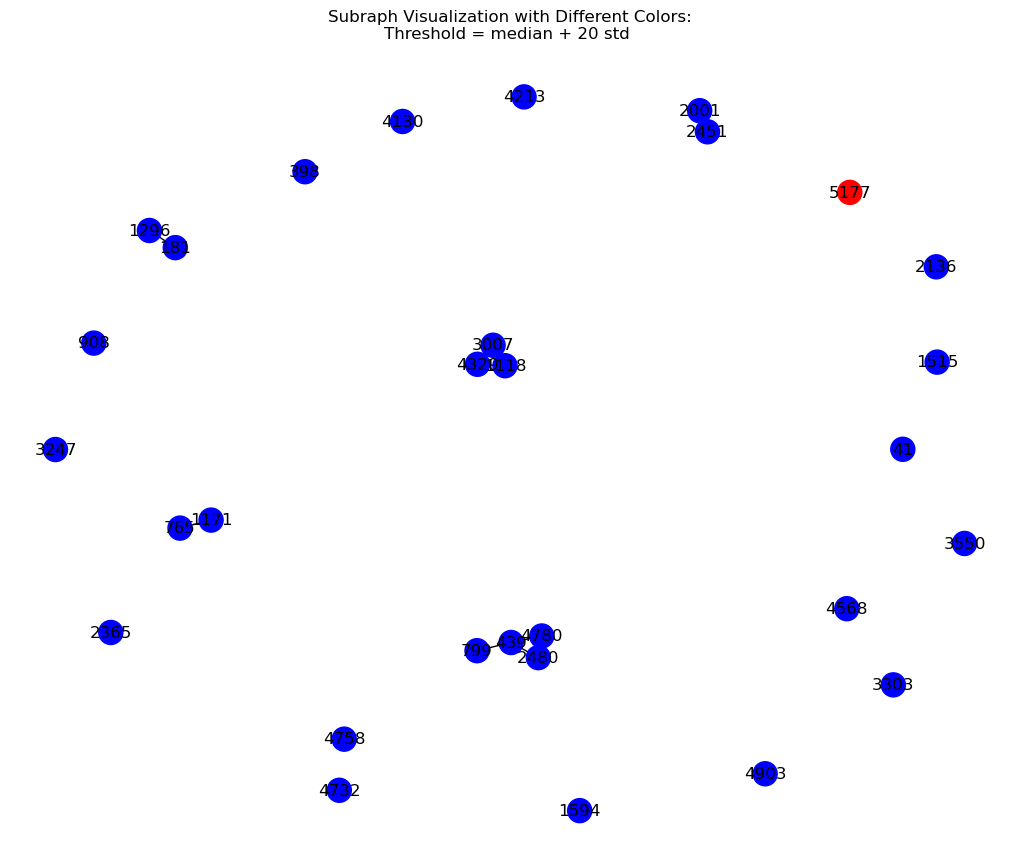

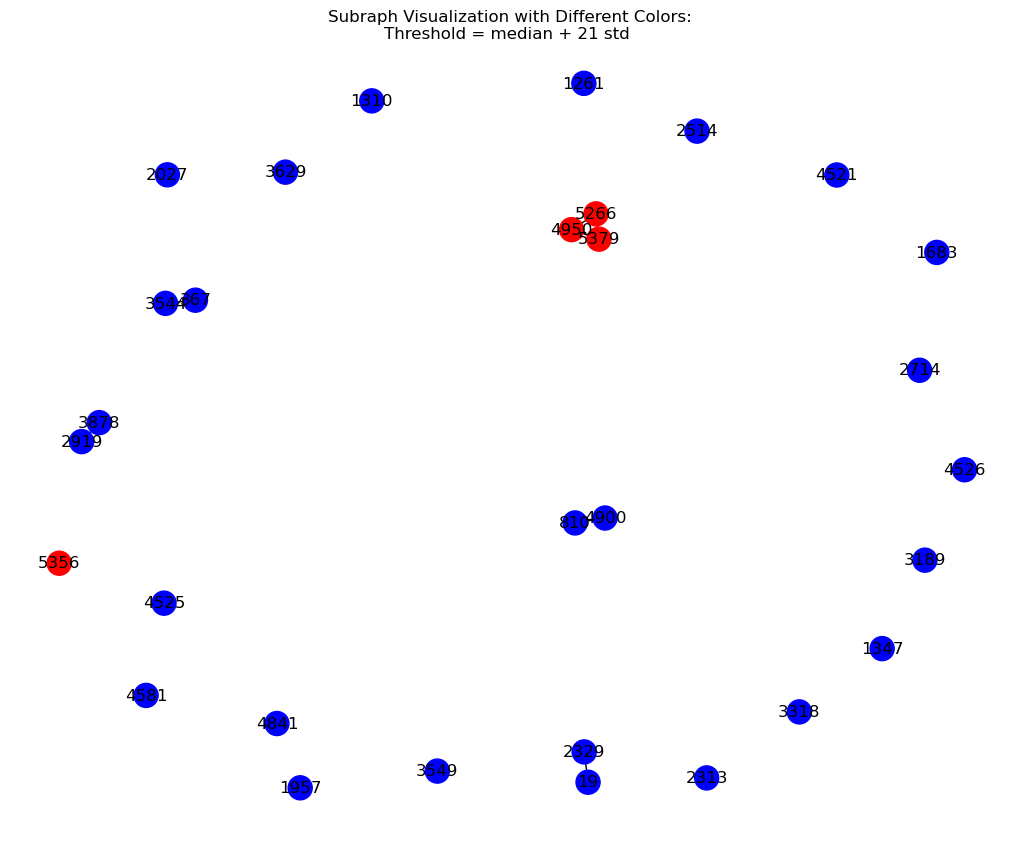

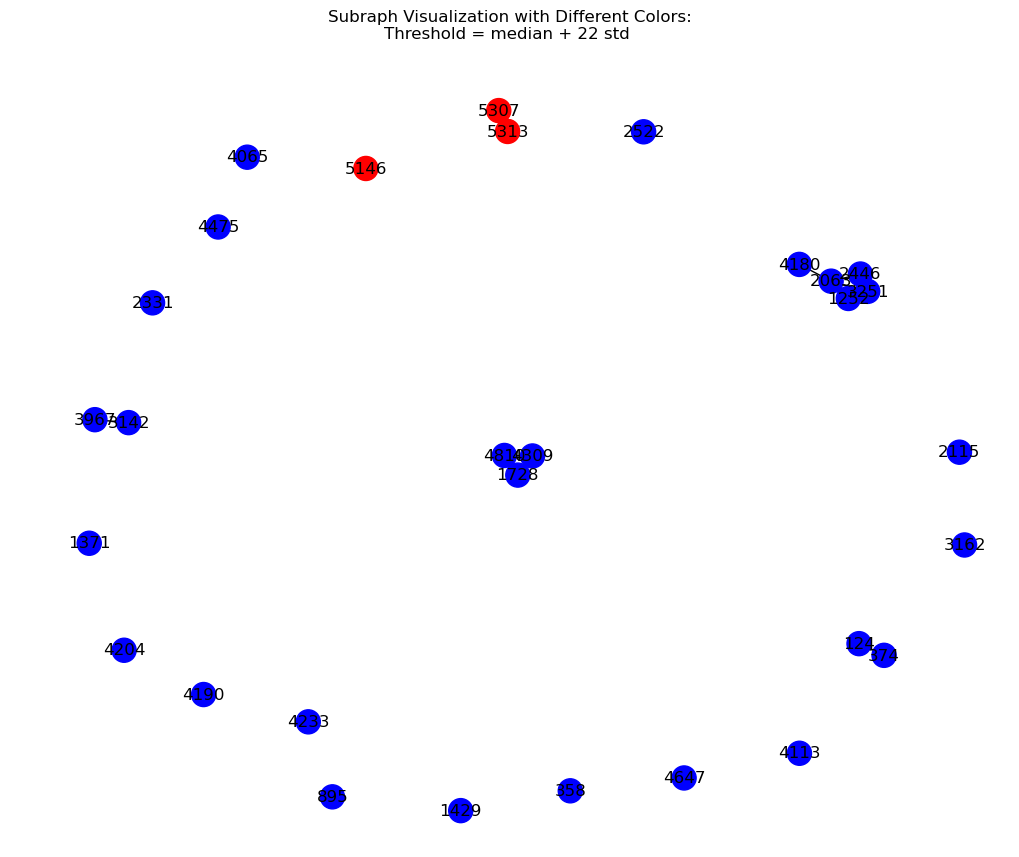

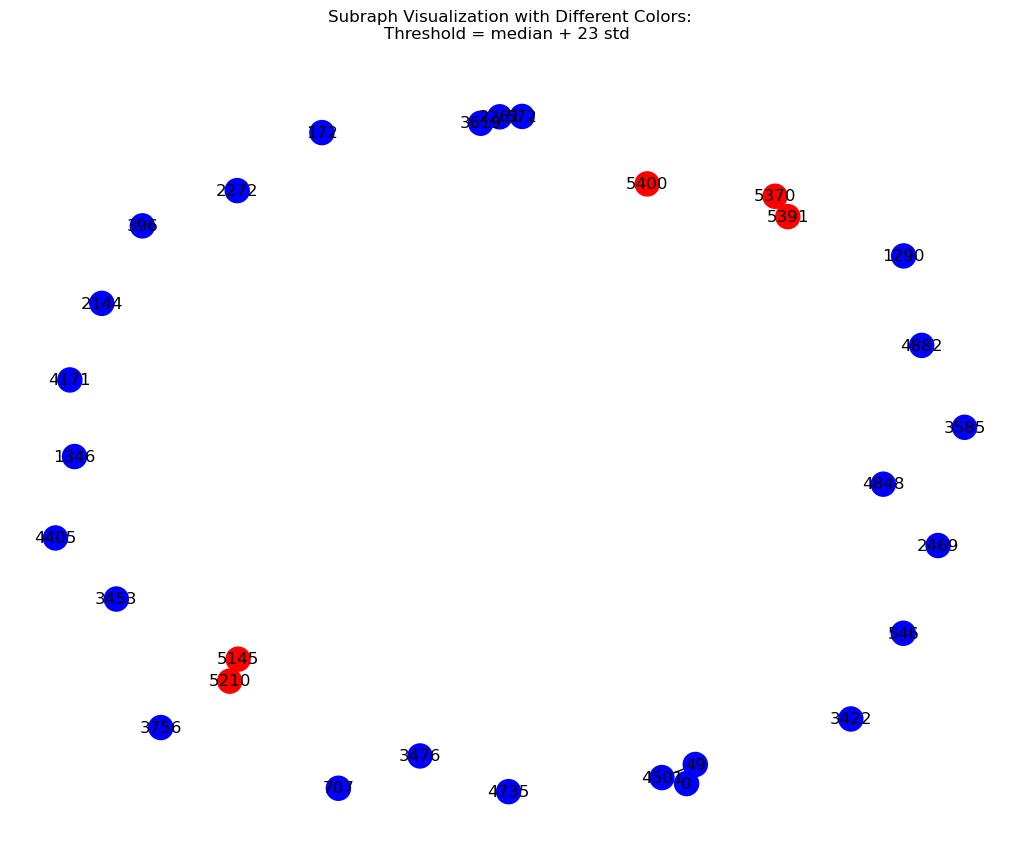

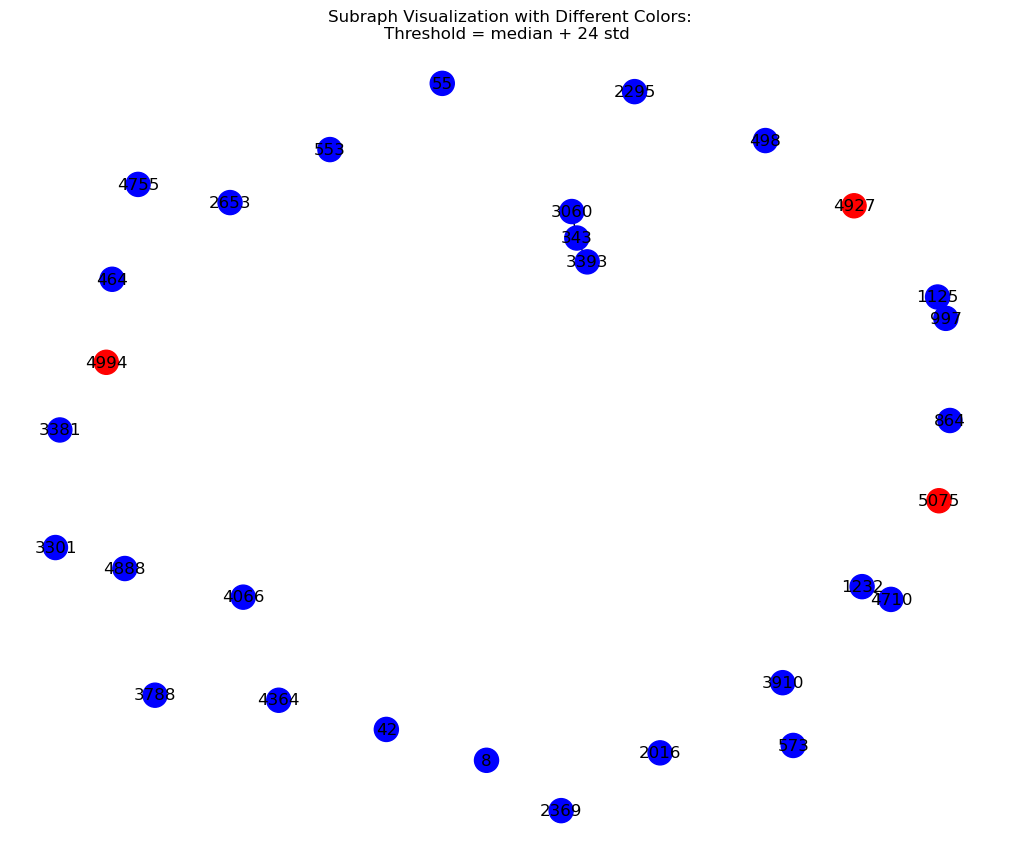

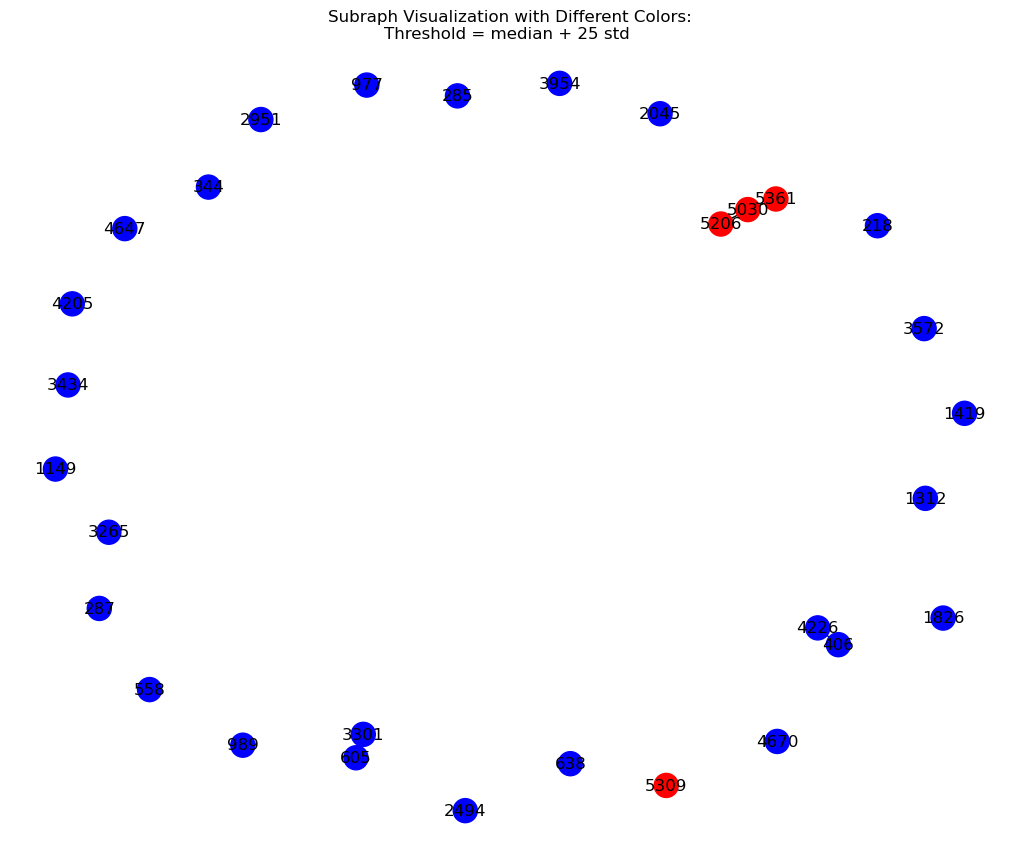

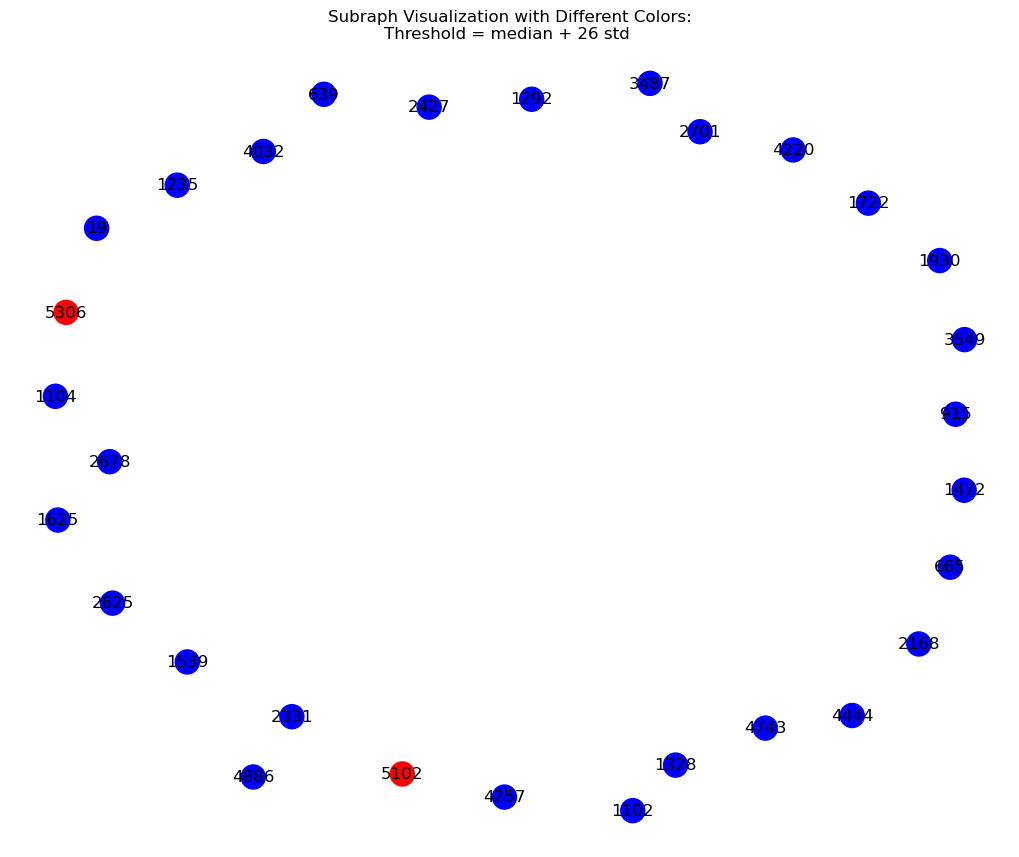

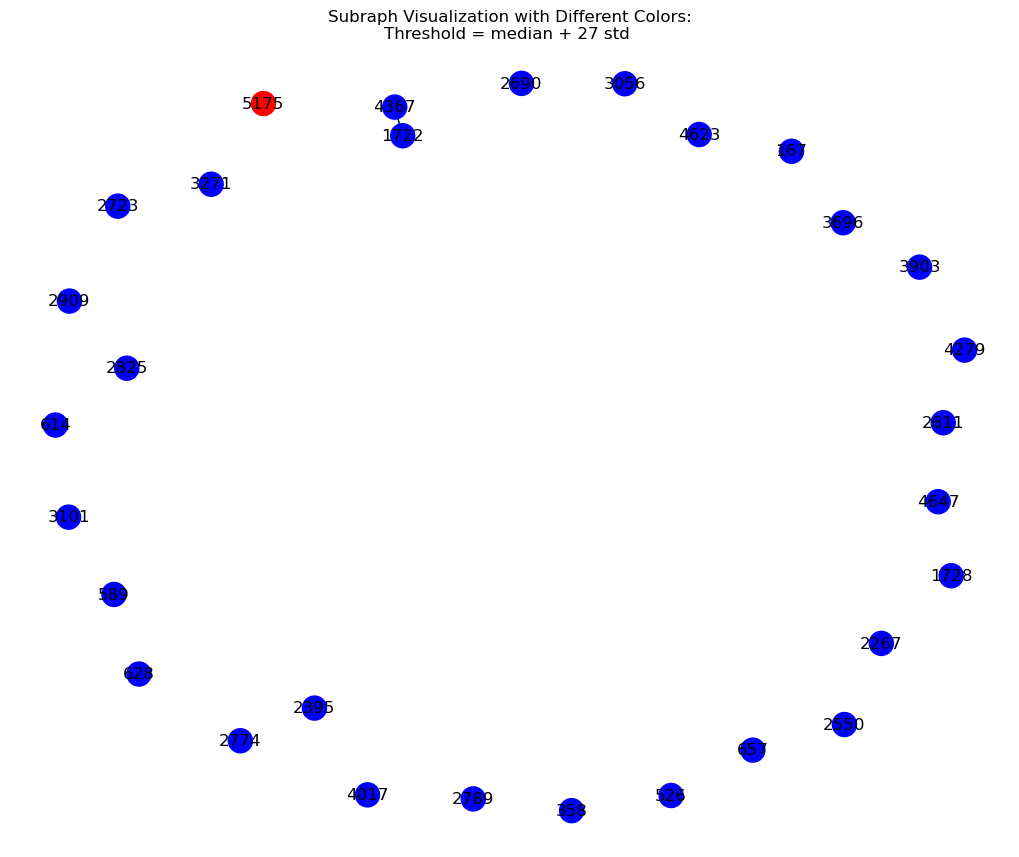

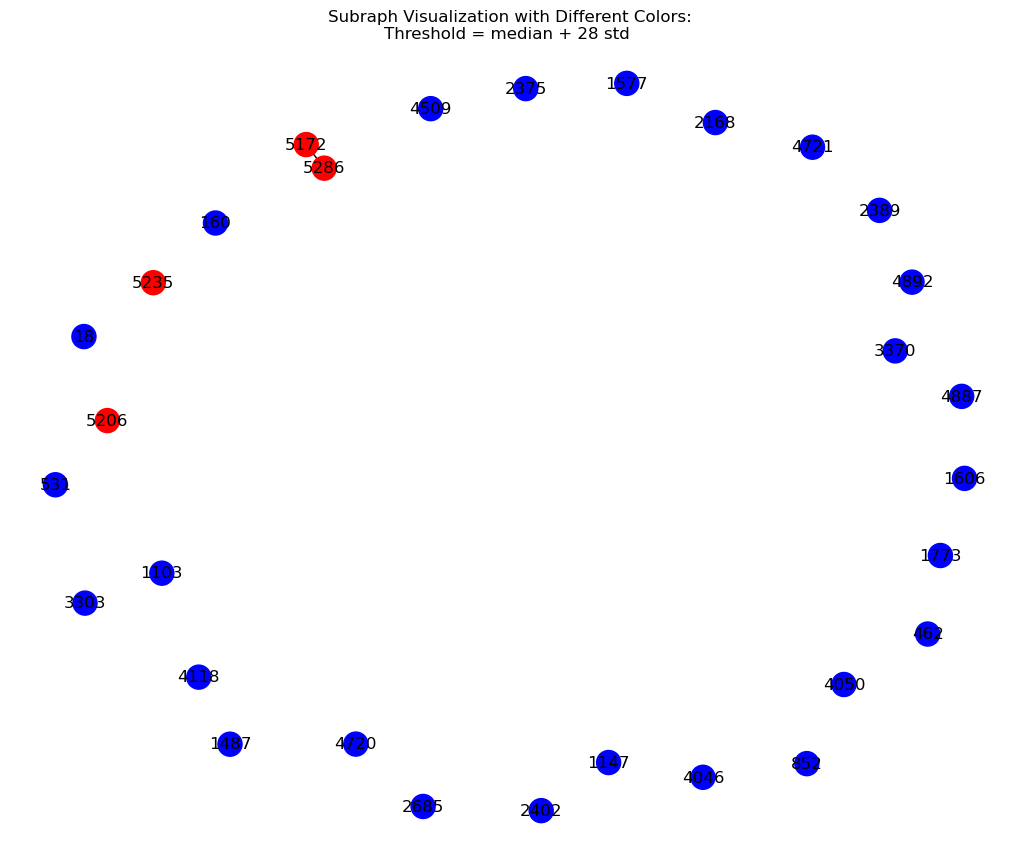

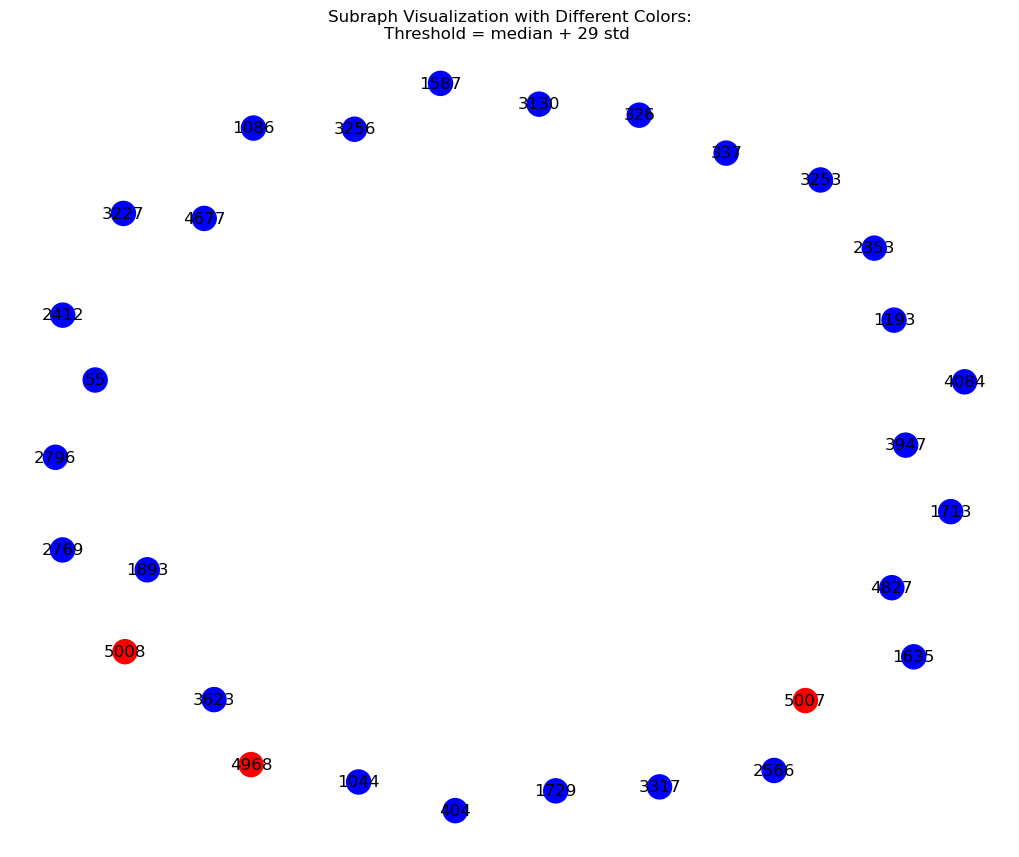

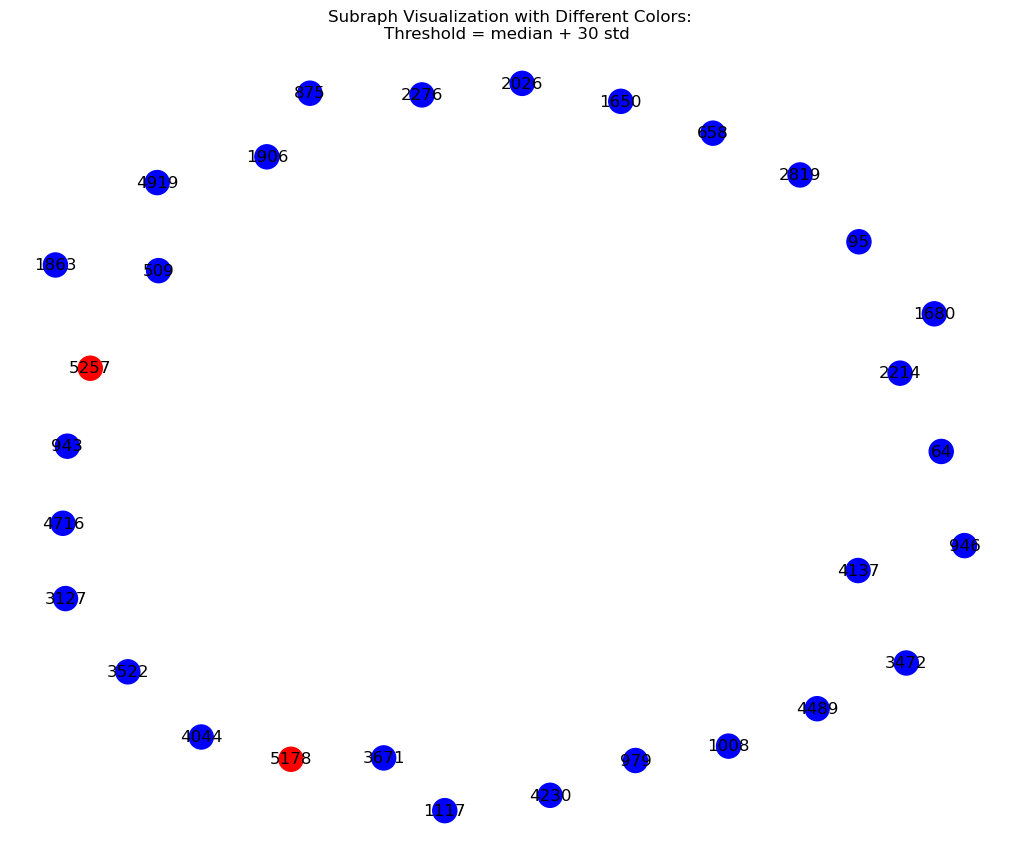

In [29]:
import matplotlib.pyplot as plt
import random
for idx,G in tqdm(enumerate(graph),desc="plot..."):
    subset_nodes = random.sample(G.nodes(), k=30)
    subgraph = G.subgraph(subset_nodes)

    # 定義顏色映射
    color_map = {0: 'blue', 1: 'red'}

    # 根據類別為節點指定顏色
    node_colors = [color_map[G.nodes[node]['Class']] for node in subgraph.nodes()]

    # 繪製子圖
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, with_labels=True, node_color=node_colors)
    plt.title(f"Subraph Visualization with Different Colors:\nThreshold = median + {idx} std ")
    # 保存图为文件
    plt.savefig(f'./plot_G/median_add_{idx}_std.png')  # 将图保存为 PNG 格式
    # plt.show()

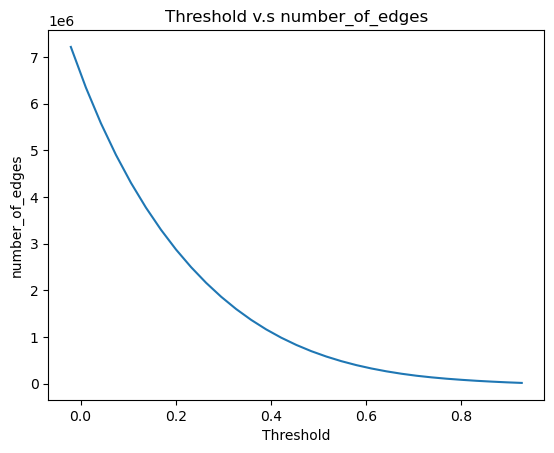

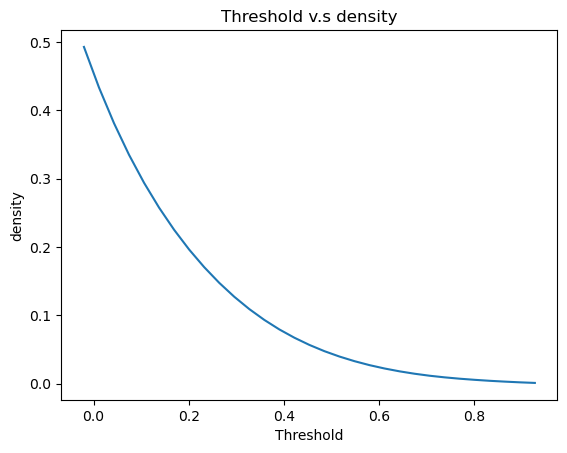

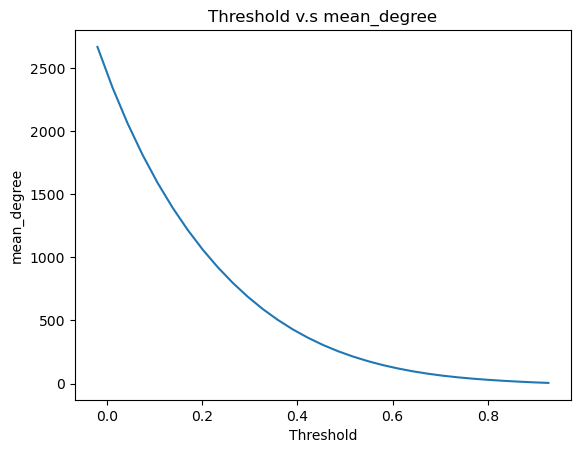

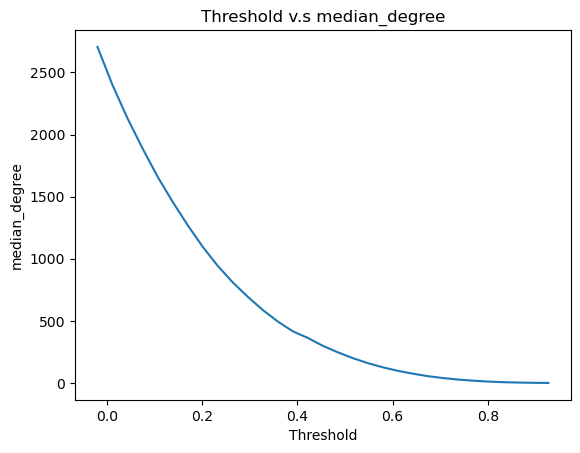

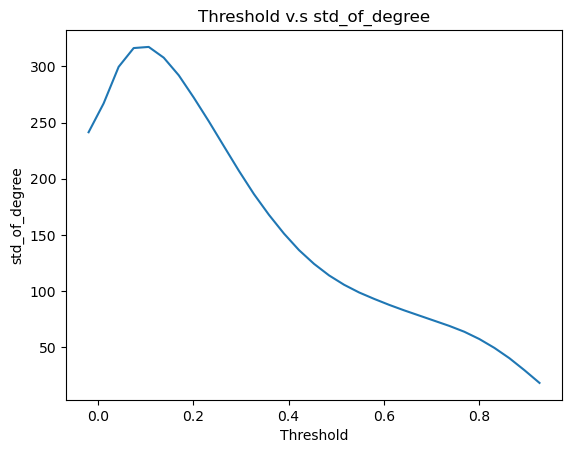

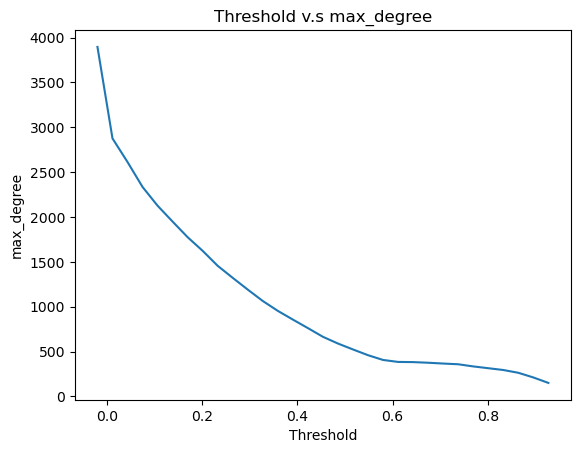

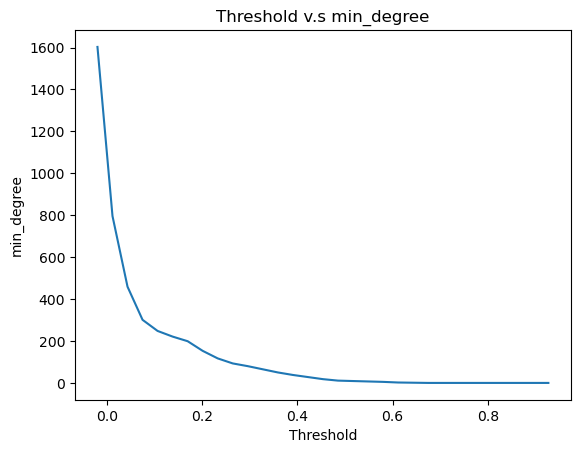

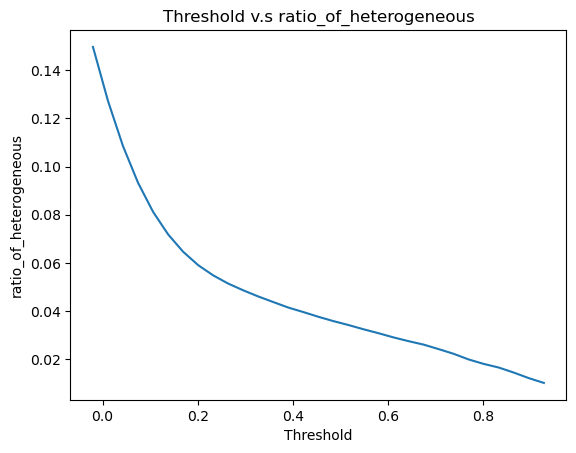

In [31]:
## plot graph construction experiments result
x=data_dic['threshold']
for key in data_dic:
    if key=='graph' or key=='threshold' or key=='number_of_nodes':
        continue
    y=data_dic[key]
    plt.figure()
    plt.plot(x,y)
    plt.title(f"Threshold v.s {key}")
    plt.xlabel("Threshold")
    plt.ylabel(f"{key}")
    plt.savefig(f"./experiments_plt/threshold_vs_{key}")
    plt.show()
    
    